# Evaluate the impact of the sampling and the seeing to the definition of the regions sizes using a fraction of the total flux as a threshold to define the size.

### The goal is to produce a function of the flux included in the real boarder of the regions as a function of its true size. 

In [1]:
# Import Libraries
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import rc
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from matplotlib.lines import Line2D
from pylab import *
import pylab as plb
from numpy import sqrt, pi, exp, loadtxt
import math
import scipy
from scipy import ndimage
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.optimize import minimize
from lmfit.models import PseudoVoigtModel
from lmfit.models import LinearModel

In [2]:
# Definition of a spherical region intensity profile 

function = np.zeros(101)    
for i in range(0,101):
    function[i] = sin(math.radians(90-180/3.14159*arcsin(i/100.)))
    


In [3]:
import numpy as np

def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

1.0
4.77441971853e-05


<IPython.core.display.Javascript object>


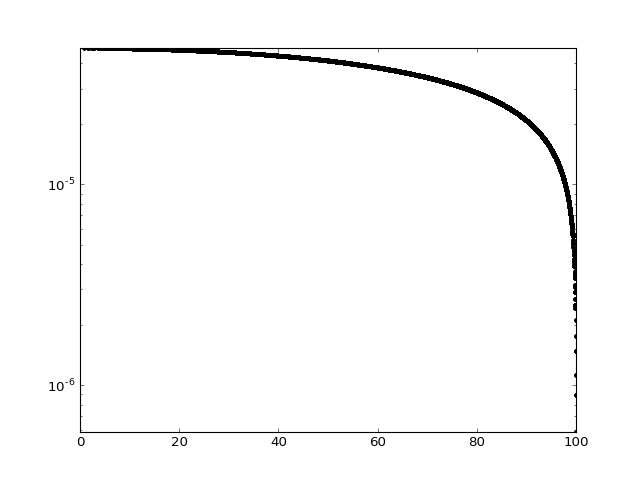

In [16]:
reg = np.zeros([300,300])
r = np.zeros([300,300])

for i in range(0,300):
        
    for j in range(0,300):
            
        # Create a map of radial distances

        r[i,j] = (math.fabs(150-0.5-i)**2.+math.fabs(150-0.5-j)**2.)**0.5
        reg[i,j] = sin(math.radians(90-180/3.14159*arcsin(r[i,j]/100)))

reg[(np.isfinite(reg) == 0)] = 0            
reg[(reg < 0)] = 0 
reg = reg/np.sum(reg)
print np.sum(reg)
print np.max(reg)
%matplotlib nbagg

plt.semilogy(r, reg,'.', c='k')
plt.ylim(0, np.max(reg))
plt.xlim(0,100)
plt.show()

<IPython.core.display.Javascript object>


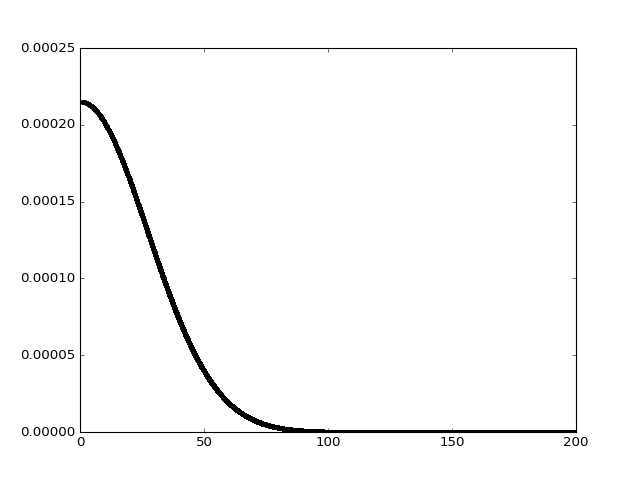

In [65]:
%matplotlib nbagg

rr = scipy.ndimage.filters.gaussian_filter(reg, 48/2.35, truncate=6.0)
rrr = scipy.ndimage.filters.gaussian_filter(rr, 42.17/2.35, truncate=6.0)

plt.plot(r, rrr,'.', c='k')
plt.xlim(0,200)
plt.show()

In [6]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


In [7]:
# 1) Create refions of different sizes from 0.0 to 300.0 pc 
# 2) Apply seeing with a gaussien convolution
# 3) Simulate the CCD spatial sampling for a given resolution (distance of the object)
# 4) Calculate the % of the flux projected outside the true size of the regions

# Variables initialization 

# Must be updated for every target

seeing = 0.9 # seeing in arcsecs
d = 9006000 # distance in parsecs
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
# plot data

#plt.plot(x, y,'b')

# Add some axis labels

plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()
flux_tot = np.zeros(300) 
flux_tot2 = np.zeros(300) 
flux_out = np.zeros(300)
flux_out2 = np.zeros(300)
flux_center2 = np.zeros(300)
size_50_2 = np.zeros(300)
size_80_2 = np.zeros(300)
flux_out3 = np.zeros(300)
flux_center3 = np.zeros(300)
size_50_3 = np.zeros(300)
size_80_3 = np.zeros(300)
taille_pixels = 0.322

scale_pixel = round(d*sin(math.radians(taille_pixels/3600.))/sin(math.radians(90-taille_pixels/3600.)))
t = scale_pixel*50. # Resolution of the modelization of the regions
sigma = seeing/taille_pixels/2.35*scale_pixel # gaussian sigma for the seeing convolution
print t
sig = np.zeros(300)

reg = np.zeros([t,t])
reg_seeing = np.zeros([t,t])
reg_seeing2 = np.zeros([t,t])
r = np.zeros([t,t])
#rrr = np.zeros(176400)
#test = np.zeros(176400)

# Loop to generate the region luminosity profile and its size : Sperical with constant intensity
    
for size in range(1,300):
    
    #print size

    for i in range(0,700):
        
        for j in range(0,700):
            
            # Create a map of radial distances

            r[i,j] = (math.fabs((t+0.2)/2-i)**2.+math.fabs((t+0.2)/2-j)**2.)**0.5

            reg[i,j] = sin(math.radians(90-180/3.14159*arcsin(r[i,j]/size)))

    reg[(np.isfinite(reg) == 0)] = 0        
    reg[(reg < 0)] = 0  
    reg = reg/np.sum(reg)
    
    # Apply seeing convolution
    
    reg_seeing = scipy.ndimage.filters.gaussian_filter(reg, sigma, truncate=4.0)
    reg_seeing = reg_seeing/np.sum(reg_seeing) # Normalisation
    flux_out2[size] = np.sum(reg_seeing[(r > size)]) # Flux lying outside the region boundaries
    flux_center2[size] = np.sum(reg_seeing[r < scale_pixel]) # Flux in the central pixel (spherical pixel)
    
    # Apply the final convolution to the data (The one applied to the datacube to improve the detection)
    
    reg_seeing2 = scipy.ndimage.filters.gaussian_filter(reg_seeing, sigma, truncate=5.0) 
    flux_out3[size] = np.sum(reg_seeing2[(r > size)]) # Flux lying outside the region boundaries
    flux_center3[size] = np.sum(reg_seeing2[r < scale_pixel]) # Flux in the central pixel (spherical pixel)
    initial_guess = (np.max(reg_seeing2),(t+0.2)/2,(t+0.2)/2,size,size,0,0)

    reg_seeing2f = np.reshape(reg_seeing2, (1,np.product(reg_seeing2.shape)))
    rf = np.reshape(r, (1,np.product(r.shape)))
    sig[size] =  np.mean(rf[0][np.where(reg_seeing2f[0] == find_nearest(reg_seeing2f[0], np.max(reg_seeing2f[0])/2))])

    #mod.set_param_hint('sigma', value=25, min=25, max=350)
    #mod.set_param_hint('fwhm', value=50)
#
    #out = mod.fit(reg_seeing2f[(reg_seeing2f > 0)], pars, x=rf[(reg_seeing2f > 0)])
    #params = out.params
    #
    #sig[size] = params['sigma']
    #frac[size] = params['fraction']
    
    
    #for i in range(0,420):
        
    #    for j in range(0,420):
            
    #        rrr[i*j] = r[i,j]
    #        test[i*j] = reg_seeing2[i,j]
   
    #x = rrr
    #y = test
    #n = len(x)                          #the number of data
    #mean = sum(x*y)/n                   #note this correction
    #sigma = sum(y*(x-mean)**2)/n        #note this correction


    #print np.max(test)
    
    #popt,pcov = curve_fit(gauss_function,x,y,p0=[np.max(test),0,size*0.95])
    #print popt
    
    
    
    for f in range(0,300):
        
        flux_tot[f] = np.sum(reg_seeing[(r < f)]) # Total flux for every distances for the center 
        flux_tot2[f] = np.sum(reg_seeing2[(r < f)]) # Total flux for every distances for the center
             
    size_50_2[size] = rr[(flux_tot > 0.5)][0]
    size_80_2[size] = rr[(flux_tot > 0.8)][0]
    size_50_3[size] = rr[(flux_tot2 > 0.5)][0]
    size_80_3[size] = rr[(flux_tot2 > 0.8)][0]


//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:126: VisibleDeprecationWarning

700.0


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:127: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 301 but corresponding boolean dimension is 300
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:128: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 301 but corresponding boolean dimension is 300
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:129: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 301 but corresponding boolean dimension is 300


In [87]:
print 'roro'


roro


<IPython.core.display.Javascript object>


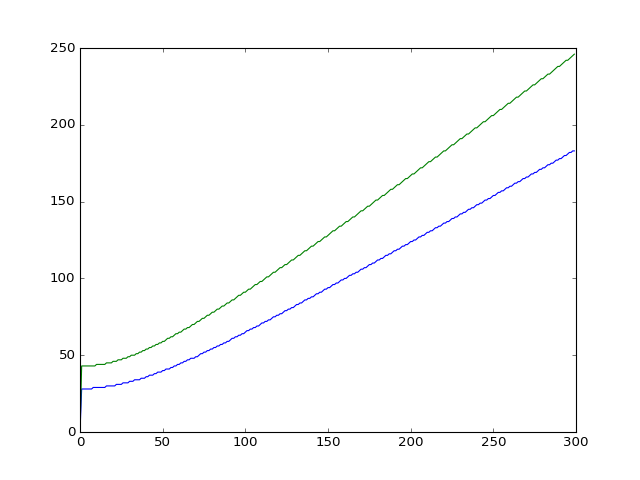

In [42]:
%matplotlib nbagg
flux_out2[0] = 1
flux_out3[0] = 1
flux_center2[0] = 0.2950
flux_center3[0] = 0.1640
#plt.plot(flux_out2)
#plt.plot(flux_out3)
#plt.plot(flux_center2)
#plt.plot(flux_center3)
#plt.plot(flux_center3)
plt.plot(size_50_3)
plt.plot(size_80_3)

#print flux_center3
#print scale_pixel
plt.xlim(0,300)
plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


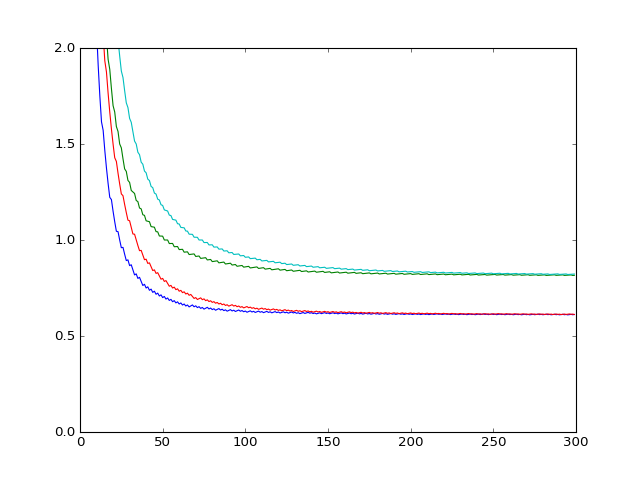

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


In [46]:
%matplotlib nbagg
plt.plot(size_50_2/np.arange(300))
plt.plot(size_80_2/np.arange(300))
plt.plot(size_50_3/np.arange(300))
plt.plot(size_80_3/np.arange(300))
plt.ylim(0,2)
plt.show()

In [43]:
fits.writeto('flux_out_vs_size.fits', flux_out2)
fits.writeto('flux_out_vs_size_conv.fits', flux_out3)
fits.writeto('flux_center_vs_size.fits', flux_center2)
fits.writeto('flux_center_vs_size_conv.fits', flux_center3)
fits.writeto('flux_50_2_size.fits', size_50_2)
fits.writeto('flux_80_2_size.fits', size_80_2)
fits.writeto('flux_50_3_size.fits', size_50_3)
fits.writeto('flux_80_3_size.fits', size_80_3)

<IPython.core.display.Javascript object>


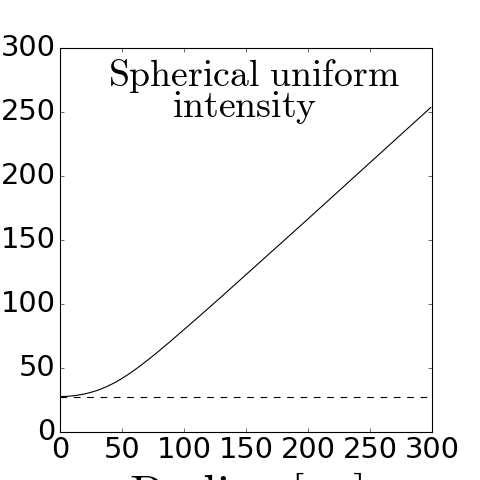

In [83]:
%matplotlib nbagg
sig[0] = 27.5
plt.figure(figsize=(6,6))
plt.plot(sig, c='k')
plt.ylabel('$\mathrm{\sigma\,\,[pc]}$', fontname='Helvetica',fontsize=44)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=44)
plt.xticks(fontsize=26.0)
plt.yticks(fontsize=26.0)
plt.rcParams['axes.facecolor'] = 'white'
plt.axhline(27.5, color='k', linestyle='--')
plt.annotate('$\mathrm{intensity}$',xy=(0.3,0.82),xycoords='axes fraction',\
            fontsize=34.0, color='k')
plt.annotate('$\mathrm{Spherical\,\,uniform}$',xy=(0.13,0.9),xycoords='axes fraction',\
            fontsize=34.0, color='k')
plt.show()
#fits.writeto('FWHM_sphere_int_uniform.fits', sig)

In [84]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_sigma_radius.eps', transparent=False, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

<IPython.core.display.Javascript object>


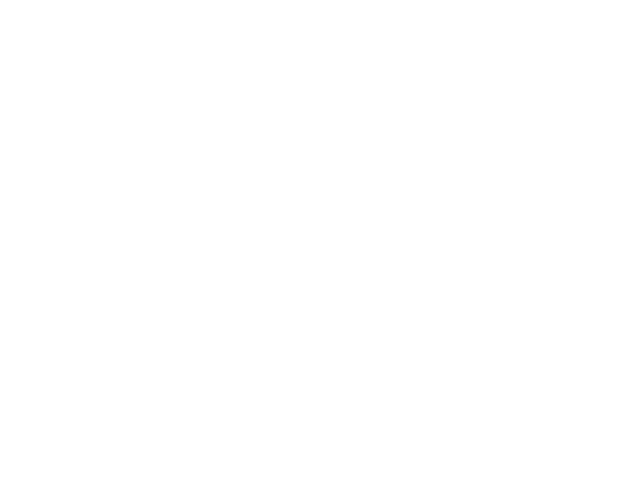

700.0
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 69
    # data points      = 241415
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -6343667.383
    Bayesian info crit = -6343646.595
[[Variables]]
    amplitude:   0.006446896 (fixed)
    sigma:       67.2460647 +/- 0.032150 (0.05%) (init= 10)
    center:      0 (fixed)
    fraction:    1.0955e-06 +/- 0.001436 (131098.82%) (init= 0)
    fwhm:        134.492129 +/- 0.064300 (0.05%)  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)
    C(sigma, fraction)           = -0.430 



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


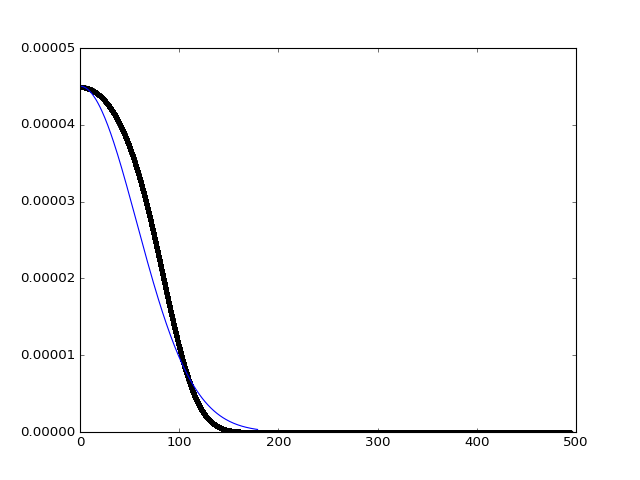

In [67]:
# 1) Create refions of different sizes from 0.0 to 300.0 pc 
# 2) Apply seeing with a gaussien convolution
# 3) Simulate the CCD spatial sampling for a given resolution (distance of the object)
# 4) Calculate the % of the flux projected outside the true size of the regions

# Variables initialization 

# Must be updated for every target

seeing = 0.9 # seeing in arcsecs
d = 9006000 # distance in parsecs

# plot data

#plt.plot(x, y,'b')

# Add some axis labels

plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()
flux_tot = np.zeros(300) 
flux_tot2 = np.zeros(300) 
flux_out = np.zeros(300)
flux_out2 = np.zeros(300)
flux_center2 = np.zeros(300)
size_50_2 = np.zeros(300)
size_80_2 = np.zeros(300)
flux_out3 = np.zeros(300)
flux_center3 = np.zeros(300)
size_50_3 = np.zeros(300)
size_80_3 = np.zeros(300)
taille_pixels = 0.322

scale_pixel = round(d*sin(math.radians(taille_pixels/3600.))/sin(math.radians(90-taille_pixels/3600.)))
t = scale_pixel*50. # Resolution of the modelization of the regions
sigma = seeing/taille_pixels/2.35*scale_pixel # gaussian sigma for the seeing convolution
print t
mod = PseudoVoigtModel()
a = np.zeros(300)
sig = np.zeros(300)
fwhm = np.zeros(300)
frac = np.zeros(300)
amp = np.zeros(300)
    
        
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0.5, min=0, max=1)
mod.set_param_hint('amplitude', value = 1)
pars = mod.make_params()

reg = np.zeros([t,t])
reg_seeing = np.zeros([t,t])
reg_seeing2 = np.zeros([t,t])
r = np.zeros([t,t])
#rrr = np.zeros(176400)
#test = np.zeros(176400)

# Loop to generate the region luminosity profile and its size : Sperical with constant intensity
    
for size in range(100,101):
    
    #print size

    for i in range(0,700):
        
        for j in range(0,700):
            
            # Create a map of radial distances

            r[i,j] = (math.fabs((t+0.2)/2-i)**2.+math.fabs((t+0.2)/2-j)**2.)**0.5

            reg[i,j] = sin(math.radians(90-180/3.14159*arcsin(r[i,j]/size)))
          
    reg[(np.isfinite(reg) == 0)] = 0        
    reg[(reg < 0)] = 0  
    reg = reg/np.sum(reg)
    
    # Apply seeing convolution
    
    reg_seeing = scipy.ndimage.filters.gaussian_filter(reg, sigma, truncate=4.0)
    reg_seeing = reg_seeing/np.sum(reg_seeing) # Normalisation
    flux_out2[size] = np.sum(reg_seeing[(r > size)]) # Flux lying outside the region boundaries
    flux_center2[size] = np.sum(reg_seeing[r < scale_pixel]) # Flux in the central pixel (spherical pixel)
    
    # Apply the final convolution to the data (The one applied to the datacube to improve the detection)
    
    reg_seeing2 = scipy.ndimage.filters.gaussian_filter(reg_seeing, sigma, truncate=5.0) 
    flux_out3[size] = np.sum(reg_seeing2[(r > size)]) # Flux lying outside the region boundaries
    flux_center3[size] = np.sum(reg_seeing2[r < scale_pixel]) # Flux in the central pixel (spherical pixel)
    initial_guess = (np.max(reg_seeing2),(t+0.2)/2,(t+0.2)/2,size,size,0,0)
    reg_seeing2f = np.reshape(reg_seeing2, (1,np.product(reg_seeing2.shape)))
    rf = np.reshape(r, (1,np.product(r.shape)))
    
    #mod = PseudoVoigtModel()
#
    #mod.set_param_hint('sigma', value=10, min=10, max=350)
    #mod.set_param_hint('fwhm', value=size)
    #mod.set_param_hint('center', value=0, vary=0)
    #mod.set_param_hint('fraction', value=0, min=0.0, max=1)
    #mod.set_param_hint('amplitude', value = np.max(reg_seeing2)/0.00696724678062, vary = 0)
    #pars = mod.make_params()
    #out = mod.fit(reg_seeing2f[(reg_seeing2f > 0)], pars, x=rf[(reg_seeing2f > 0)])
    #params = out.params
    #
    #a2 = params['amplitude']
    #cent2 = params['center']
    #sig2 = params['sigma']
    #frac2 = params['fraction']
    #sigg2 = params['fwhm']
#

#print(out.fit_report(min_correl=0.25))

%matplotlib nbagg
    
#plt.plot(r,reg_seeing2, '.k')
#plt.plot(np.arange(180), ((1-frac2)*a2*np.exp(-(np.arange(180)-cent2)**2/(2*(sig2/(2*np.log(2))**0.5)**2))/((sig2/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac2*a2*sig2/(np.pi*((np.arange(180)-cent2)**2+sig2**2))), 'b-')

plt.show()

In [52]:
print np.max(((1-frac2)*a2*np.exp(-(np.arange(180)-cent2)**2/(2*(sig2/(2*np.log(2))**0.5)**2))/((sig2/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac2*a2*sig2/(np.pi*((np.arange(180)-cent2)**2+sig2**2))))/np.max(reg_seeing2)


1.15991213445


In [55]:
print np.max(np.max(((1-frac2)*a2*np.exp(-(np.arange(180)-cent2)**2/(2*(sig2/(2*np.log(2))**0.5)**2))/((sig2/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac2*a2*sig2/(np.pi*((np.arange(180)-cent2)**2+sig2**2)))))/np.max(reg_seeing2)

1.15991213445


In [56]:
print a2/1.15991213445

0.00644689565224


In [66]:
print np.max(reg_seeing2)/0.00696724678062

0.00644689565224


In [34]:
plt.plot?